# Preprocessing

Importing needed libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dask
import joblib
import warnings
from dask.distributed import LocalCluster, Client
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, TargetEncoder
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, f1_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from umap import UMAP
warnings.filterwarnings('ignore')

Initialize cluster

In [2]:
cluster = LocalCluster(n_workers = 4, threads_per_worker = 1, memory_limit = '6GB')
client = Client(cluster)

Reading csv file

In [5]:
df = pd.read_csv('datasets/Churn.csv', low_memory = False)
df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


Checking dtypes

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71047 entries, 0 to 71046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 71047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             70831 non-null  float64
 3   MonthlyMinutes             70831 non-null  float64
 4   TotalRecurringCharge       70831 non-null  float64
 5   DirectorAssistedCalls      70831 non-null  float64
 6   OverageMinutes             70831 non-null  float64
 7   RoamingCalls               70831 non-null  float64
 8   PercChangeMinutes          70545 non-null  float64
 9   PercChangeRevenues         70545 non-null  float64
 10  DroppedCalls               71047 non-null  float64
 11  BlockedCalls               71047 non-null  float64
 12  UnansweredCalls            71047 non-null  float64
 13  CustomerCareCalls          71047 non-null  flo

Verifying null values

In [7]:
# grabbing all missing values
total_missing = df.isnull().sum().reset_index().rename(columns = {'index': 'feature', 0: 'missing_count'})

# selecting ones whic have missing_count greater than 0
actual_missing = total_missing[total_missing.missing_count > 0].copy().reset_index(drop = True)

# showing in terms of relative percentages
actual_missing['missin_count_relavite'] = actual_missing['missing_count'] / len(df)

# adding its dtypes
dtype_dict = df.dtypes.to_dict()
actual_missing['dtype'] = actual_missing.feature.map(dtype_dict)

# missing dataframe
actual_missing

,feature,missing_count,missin_count_relavite,dtype
0,Churn,20000,0.281504,object
1,MonthlyRevenue,216,0.003040,float64
2,MonthlyMinutes,216,0.003040,float64
3,TotalRecurringCharge,216,0.003040,float64
4,DirectorAssistedCalls,216,0.003040,float64
5,OverageMinutes,216,0.003040,float64
6,RoamingCalls,216,0.003040,float64
7,PercChangeMinutes,502,0.007066,float64
8,PercChangeRevenues,502,0.007066,float64
9,ServiceArea,28,0.000394,object


As it can be seen, there are 20000 missing values on the target "Churn", this group is stored in another datadrame for future purposes, but as first step we clean the null values by dropping their rows cause they represent fewer than 2%

In [8]:
# drop null values
values_to_drop = actual_missing.feature.tolist()[1:]

df = df.dropna(subset = values_to_drop, axis = 0)

# getting those
df_no_target = df[df.Churn.isnull()].copy().reset_index(drop = True)

# dropping 20000 nan values in the original dataframe
df = df.dropna(subset = 'Churn')

# removing churn feature from actual_missing
actual_missing = actual_missing[actual_missing.feature != 'Churn']

# verifying new shape
df.shape

(49752, 58)

Verifying null values

In [9]:
df.isnull().sum().sum()

0

Labeling target

In [10]:
df['Churn'] = np.where(df['Churn'] == 'Yes', 1, 0)

Creating a class to clean outliers

In [11]:
class CleanOutliers(TransformerMixin):
    def __init__(self):
        '''
        Treat outliers
        '''
    def set_output(self, transform = 'pandas'):
        return self

    def _get_boundaries(self, X_feature):
        q1 = X_feature.quantile(0.25)
        q3 = X_feature.quantile(0.75)
        irs = q3 - q1
        lower_bound = q1 - 1.5 * irs
        upper_bound = q3 + 1.5 * irs
        return lower_bound, upper_bound

    def fit(self, X, y = None):
        self.boundary = {column: self._get_boundaries(X[column]) for column in X.columns}
        return self

    def transform(self, X, y = None):
        X_gei = X.copy()
        current_columns = X_gei.columns.tolist()
        for column in current_columns:
            lower_bound, upper_bound = self.boundary[column]
            X_gei[column] = X_gei[column].clip(lower = lower_bound,
                                        upper = upper_bound)
        return X_gei.copy()

Verfying categorical values before performing encoding

In [12]:
cat_features = df.describe(include = object).T
cat_features_to_regroup = cat_features[cat_features.unique > 4]
cat_features_to_regroup

,count,unique,top,freq
ServiceArea,49752,743,NYCBRO917,1646
HandsetPrice,49752,16,Unknown,28263
CreditRating,49752,7,2-High,18692
Occupation,49752,8,Other,36453


Selecting those columns to check on its values

In [13]:
df_cat_features_to_regroup = df[['ServiceArea', 'HandsetPrice', 'CreditRating', 'Occupation']]
df_cat_features_to_regroup

,ServiceArea,HandsetPrice,CreditRating,Occupation
0,SEAPOR503,30,1-Highest,Professional
1,PITHOM412,30,4-Medium,Professional
2,MILMIL414,Unknown,3-Good,Crafts
3,PITHOM412,10,4-Medium,Other
4,OKCTUL918,10,1-Highest,Professional
...,...,...,...,...
51035,NEVELC619,Unknown,2-High,Professional
51037,NEVENC760,Unknown,3-Good,Other
51040,LAXVNY818,Unknown,1-Highest,Professional
51041,LAXDOW562,30,5-Low,Professional


Value counts per cat feature

In [14]:
df.ServiceArea.value_counts()

NYCBRO917    1646
DALDAL214    1479
HOUHOU281    1471
NYCMAN917    1156
DALFTW817     771
             ... 
SANROM956       1
INDCRA765       1
SEWSUN509       1
ATLDBL478       1
NCRDNN910       1
Name: ServiceArea, Length: 743, dtype: int64

In [15]:
df.HandsetPrice.value_counts()

Unknown    28263
30          7147
150         4024
130         2043
80          1901
10          1869
60          1730
200         1227
100         1209
40           240
400           45
250           20
300           12
180            9
500            7
240            6
Name: HandsetPrice, dtype: int64

Creating a function to regroup specific features

In [16]:
df.HandsetPrice.unique()

array(['30', 'Unknown', '10', '80', '150', '300', '40', '200', '100',
       '130', '60', '400', '240', '250', '180', '500'], dtype=object)

In [17]:
def regroup_cat_values(data):
    # ServiceArea
    top_4 = df.ServiceArea.value_counts().head(4).index.tolist()
    data['ServiceArea'] = np.where(data['ServiceArea'].isin(top_4),
                                    data['ServiceArea'],
                                    'OTHER')
    # HandsetPrice
    data['HandsetPrice'] = np.where(data['HandsetPrice'] == 'Unknown', '30', data['HandsetPrice'])
    data['HandsetPrice'] = data['HandsetPrice'].astype('int16')

    return data

Apply the function to both dataframes

In [18]:
df = regroup_cat_values(df)
df_no_target = regroup_cat_values(df_no_target)

In [19]:
df.describe(include = object).T

,count,unique,top,freq
ServiceArea,49752,5,OTHER,44000
ChildrenInHH,49752,2,No,37483
HandsetRefurbished,49752,2,No,42852
HandsetWebCapable,49752,2,Yes,44905
TruckOwner,49752,2,No,40280
RVOwner,49752,2,No,45619
Homeownership,49752,2,Known,33725
BuysViaMailOrder,49752,2,No,31432
RespondsToMailOffers,49752,2,No,30667
OptOutMailings,49752,2,No,49006


It is observed that can be label encoded is CreditRating

In [20]:
df.CreditRating.unique()

array(['1-Highest', '4-Medium', '3-Good', '2-High', '5-Low', '6-VeryLow',
       '7-Lowest'], dtype=object)

Creating a local class for label encoding

Splitting dataframe

In [21]:
# Getting X and y matrices
X = df.drop(columns = ['CustomerID','Churn'])
y = df.Churn

# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 24)

Performing the final treatment

In [22]:
# selecting dtypes
num_col = X_train.select_dtypes(include = np.number).columns.tolist()
cat_col = X_train.select_dtypes(include = ['object', 'category']).columns.tolist()

# creating pipelines or transformers
num_prep = Pipeline([('outlier', CleanOutliers().set_output(transform ='pandas')),
                    ('impute', SimpleImputer(strategy = 'mean').set_output(transform = 'pandas'))])

cat_prep = TargetEncoder(random_state=23).set_output(transform = 'pandas')

# creating transformer
column_transformer = ColumnTransformer([('num', num_prep, num_col),
                                        ('cat', cat_prep, cat_col)],
                                        remainder = 'passthrough')\
                                    .set_output(transform = 'pandas')

# testing transformer
X_train_tr = column_transformer.fit_transform(X_train, y_train)

Removing multivariate outliers from testing set

In [23]:
# In order to verify outlier groups, it is important to reduce the data into a two-featured one so that the
# minority class would be considered as outlier
min_samples = len(X_train) * 0.05
reducer = UMAP(n_components = 2, random_state = 23)
detector = DBSCAN(eps = 1.2, min_samples = int(min_samples), n_jobs = -1)
# scaling
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_tr)
# reducing
X_train_re = reducer.fit_transform(X_train_sc)
# detecting labels
labels = detector.fit_predict(X_train_re)

Plotting classes

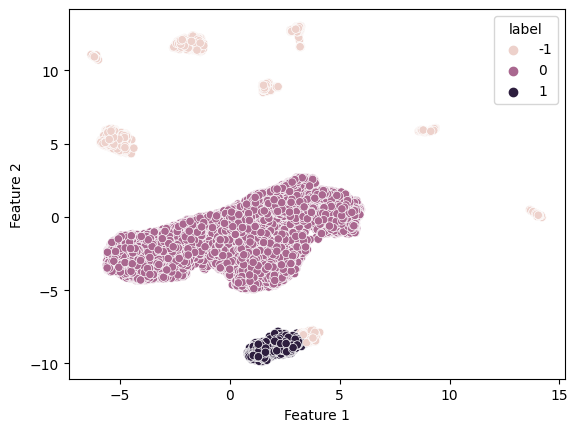

In [24]:
evaluator = pd.DataFrame(X_train_re, columns = ['Feature 1', 'Feature 2'])
outlier = pd.DataFrame(labels, columns = ['label'])
evaluator = pd.concat([evaluator, outlier], axis = 1)
sns.scatterplot(evaluator, x = 'Feature 1', y = 'Feature 2', hue = 'label')
plt.show()

Creating a class to clean multivariate outliers

In [25]:
class MultivariateOutliers(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        Removes outliers
        """
    def set_output(self, transform = 'pandas'):
        return self

    def fit(self, X, y = None):
        scaler = StandardScaler()
        reducer = UMAP(n_components = 2, random_state = 23)
        self.pipe_transform = make_pipeline(scaler, reducer)
        self.pipe_transform.fit(X)
        return self

    def transform(self, X, y):
        min_samples = len(X) * 0.05
        X_tr = self.pipe_transform.transform(X)
        detector = DBSCAN(eps = 1.2, min_samples = int(min_samples), n_jobs = -1)
        labels = detector.fit_predict(X_tr)
        outlier = pd.DataFrame(labels, columns = ['label'])
        df = pd.concat([X, y], axis = 1).reset_index(drop = True)
        data = pd.concat([df, outlier], axis = 1)
        most_common = data.label.value_counts().index.values[0]
        data = data[data['label'] == most_common].drop(columns = 'label')
        return data.drop(columns = 'Churn'), data.Churn

Removing outliers

In [26]:
# declaring outlier detector
outlier_removal = MultivariateOutliers()

# transform features
X_train_tr = column_transformer.fit_transform(X_train, y_train)
X_test_tr = column_transformer.transform(X_test)

# removing outliers
outlier_removal.fit(X_train_tr)
X_train_tr, y_train_tr = outlier_removal.transform(X_train_tr, y_train)

# Data Modelling

Creating a function to evaluate performance

In [27]:
def evaluation_metric(model_name, y_train_probs, y_test_probs, y_train_actual, y_train_pred, y_test_actual, y_test_pred):
    roc_auc_train = roc_auc_score(y_train_actual, y_train_probs)
    roc_auc_test = roc_auc_score(y_test_actual, y_test_probs)

    gini_train = 2 * roc_auc_train - 1
    gini_test = 2 * roc_auc_test - 1

    recall_train = recall_score(y_train_actual, y_train_pred)
    recall_test = recall_score(y_test_actual, y_test_pred)

    precision_train = precision_score(y_train_actual, y_train_pred)
    precision_test = precision_score(y_test_actual, y_test_pred)

    f1_train = f1_score(y_train_actual, y_train_pred)
    f1_test = f1_score(y_test_actual, y_test_pred)

    accuracy_train = accuracy_score(y_train_actual, y_train_pred)
    accuracy_test = accuracy_score(y_test_actual, y_test_pred)

    # Table creation
    results_dict = {f'{model_name} Train set': [roc_auc_train, gini_train, recall_train, precision_train, f1_train, accuracy_train],
                f'{model_name} Test set': [roc_auc_test, gini_test, recall_test, precision_test, f1_test, accuracy_test]}

    results = pd.DataFrame(results_dict, index = ['ROC AUC Score', 'Gini Score', 'Recall Score', 'Precision Score',
                                                'F1 Score', 'Accuracy Score'])
    return results

Creating base models

In [28]:
# classifiers and scaler
scaler = StandardScaler()
lr = LogisticRegression(class_weight = 'balanced', random_state = 24, n_jobs = -1)
knn = KNeighborsClassifier(weights = 'distance', n_jobs = -1)
dtc = DecisionTreeClassifier(class_weight = 'balanced', random_state = 24)
rfc = RandomForestClassifier(class_weight = 'balanced', random_state = 24)
xgb = XGBClassifier(scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state = 24, n_jobs = -1)
lgbm = LGBMClassifier(class_weight = 'balanced', random_state = 24, n_jobs = -1)
mlp = MLPClassifier(hidden_layer_sizes = (4, 4), random_state = 24, solver = 'adam', activation = 'relu')

# declaring pipelines
lr_pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', lr)])
knn_pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', knn)])
dtc_pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', dtc)])
rfc_pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', rfc)])
xgb_pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', xgb)])
lgbm_pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', lgbm)])
mlp_pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', mlp)])

# fitting pipelines
with joblib.parallel_backend('dask', scatter = (X_train, y_train)):
    lr_pipe.fit(X_train, y_train)
    knn_pipe.fit(X_train, y_train)
    dtc_pipe.fit(X_train, y_train)
    rfc_pipe.fit(X_train, y_train)
    xgb_pipe.fit(X_train, y_train)
    lgbm_pipe.fit(X_train, y_train)
    mlp_pipe.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 11401, number of negative: 28400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3521
[LightGBM] [Info] Number of data points in the train set: 39801, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Base metrics

In [29]:
total_metrics = pd.DataFrame()

pipes = [('LR', lr_pipe), ('KNN', knn_pipe), ('DTC', dtc_pipe),
         ('RFC', rfc_pipe), ('XGB', xgb_pipe), ('LGBM', lgbm_pipe),
         ('MLP', mlp_pipe)]

for clf_name, clf in pipes:
    y_train_pred_probs = clf.predict_proba(X_train)[:, 1]
    y_test_pred_probs = clf.predict_proba(X_test)[:, 1]

    y_train_pred_class = clf.predict(X_train)
    y_test_pred_class = clf.predict(X_test)

    result = evaluation_metric(clf_name, y_train_pred_probs, y_test_pred_probs,
                                y_train, y_train_pred_class, y_test, y_test_pred_class)

    total_metrics = pd.concat([total_metrics, result], axis = 1)

total_metrics

,LR Train set,LR Test set,KNN Train set,KNN Test set,DTC Train set,DTC Test set,RFC Train set,RFC Test set,XGB Train set,XGB Test set,LGBM Train set,LGBM Test set,MLP Train set,MLP Test set
ROC AUC Score,0.626755,0.620684,0.977146,0.543598,0.848646,0.539888,0.998549,0.663821,0.879383,0.661066,0.777032,0.683827,0.640344,0.629762
Gini Score,0.253510,0.241367,0.954293,0.087196,0.697292,0.079777,0.997098,0.327642,0.758766,0.322132,0.554064,0.367655,0.280688,0.259525
Recall Score,0.591615,0.584740,0.790106,0.172996,0.794229,0.342475,0.788264,0.050985,0.784493,0.507032,0.730111,0.620253,0.048768,0.037623
Precision Score,0.366457,0.369145,0.952321,0.341430,0.766853,0.342837,0.995018,0.599174,0.615808,0.413181,0.472632,0.405704,0.535645,0.457265
F1 Score,0.452578,0.452579,0.863663,0.229638,0.780301,0.342656,0.879655,0.093973,0.689990,0.455320,0.573812,0.490545,0.089396,0.069526
Accuracy Score,0.590035,0.595719,0.928545,0.668275,0.871888,0.624460,0.938218,0.719023,0.798070,0.653301,0.689329,0.631796,0.715409,0.712190


# Hyperparameter Tuning with Bayesian Search :)

Setting a function to compare metrics

In [30]:
def compare_base_tuner(name, base_pipe, tuned_pipe):
    total_metrics = pd.DataFrame()
    pipes = [(name, base_pipe), (f'{name}_TUNED', tuned_pipe.best_estimator_)]

    for clf_name, clf in pipes:
        y_train_pred_probs = clf.predict_proba(X_train)[:, 1]
        y_test_pred_probs = clf.predict_proba(X_test)[:, 1]

        y_train_pred_class = clf.predict(X_train)
        y_test_pred_class = clf.predict(X_test)

        result = evaluation_metric(clf_name, y_train_pred_probs, y_test_pred_probs,
                                    y_train, y_train_pred_class, y_test, y_test_pred_class)

        total_metrics = pd.concat([total_metrics, result], axis = 1)

    return total_metrics

## Logistic Regression

In [32]:
%%time

# creating model
model = LogisticRegression(class_weight = 'balanced', random_state = 24, n_jobs = -1)
pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', model)])
hyperparameter_ranges = {
    'clf__C': Real(1, 100),
    'clf__solver': Categorical(['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']),
    'clf__penalty': Categorical(['l2', None]),
    'clf__max_iter': Integer(100, 500),
}

# creating grid
lr_bayes_search = BayesSearchCV(estimator = pipe,
                              search_spaces = hyperparameter_ranges,
                              n_jobs=-1,
                              cv = 10,
                              scoring = 'recall',
                              error_score = 0,
                              random_state = 23,
                              return_train_score = True)
lr_bayes_search.fit(X_train, y_train)

CPU times: user 2min 45s, sys: 57.1 s, total: 3min 42s
Wall time: 15min 1s


BayesSearchCV(cv=10, error_score=0,
              estimator=Pipeline(steps=[('prep',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('num',
                                                                          Pipeline(steps=[('outlier',
                                                                                           <__main__.CleanOutliers object at 0x7bc8ae7af910>),
                                                                                          ('impute',
                                                                                           SimpleImputer())]),
                                                                          ['MonthlyRevenue',
                                                                           'MonthlyMinutes',
                                                                           'TotalRecurringCharge',
                                                                           'DirectorAssistedCalls',
                                                                           'OverageMinutes',
                                                                           'RoamingCalls',
                                                                           '...
              n_jobs=-1, random_state=23, return_train_score=True,
              scoring='recall',
              search_spaces={'clf__C': Real(low=1, high=100, prior='uniform', transform='normalize'),
                             'clf__max_iter': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                             'clf__penalty': Categorical(categories=('l2', None), prior=None),
                             'clf__solver': Categorical(categories=('lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'), prior=None)})

In [33]:
lr_bayes_search.best_params_

OrderedDict([('clf__C', 19.093626973347316),
             ('clf__max_iter', 126),
             ('clf__penalty', 'l2'),
             ('clf__solver', 'newton-cg')])

In [34]:
lr_pipe[-1].get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 24,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [35]:
lr_metrics = compare_base_tuner('LR', lr_pipe, lr_bayes_search)
lr_metrics


,LR Train set,LR Test set,LR_TUNED Train set,LR_TUNED Test set
ROC AUC Score,0.626755,0.620684,0.626755,0.620688
Gini Score,0.253510,0.241367,0.253511,0.241376
Recall Score,0.591615,0.584740,0.591615,0.584740
Precision Score,0.366457,0.369145,0.366437,0.369227
F1 Score,0.452578,0.452579,0.452563,0.452640
Accuracy Score,0.590035,0.595719,0.590010,0.595820


## KNN

In [ ]:
%%time

# creating model
model = KNeighborsClassifier(weights = 'distance', n_jobs = -1)
pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', model)])
hyperparameter_ranges = {
    'clf__n_neighbors': Integer(2, 10),
    'clf__p': Integer(1, 2)
}

# creating grid
knn_bayes_search = BayesSearchCV(estimator = pipe,
                              search_spaces = hyperparameter_ranges,
                              n_jobs=-1,
                              cv = 10,
                              scoring = 'recall',
                              error_score = 0,
                              random_state = 23,
                              return_train_score = True)
knn_bayes_search.fit(X_train, y_train)

In [ ]:
knn_bayes_search.best_params_

In [ ]:
knn_metrics = compare_base_tuner('KNN', knn_pipe, knn_bayes_search)
knn_metrics

## Decision Tree

In [ ]:
%%time

# creating model
model = DecisionTreeClassifier(class_weight = 'balanced', random_state = 24)
pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', model)])
hyperparameter_ranges = {
    'clf__criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'clf__splitter': Categorical(['best', 'random']),
    'clf__max_depth': Integer(2, 15),
    'clf__min_samples_split': Integer(2, 10),
    'clf__min_samples_leaf': Integer(1, 10),
    'clf__max_features': Categorical(['sqrt', 'log2'])
}

# creating grid
dct_bayes_search = BayesSearchCV(estimator = pipe,
                              search_spaces = hyperparameter_ranges,
                              n_jobs=-1,
                              cv = 10,
                              scoring = 'recall',
                              error_score = 0,
                              random_state = 23,
                              return_train_score = True)
dct_bayes_search.fit(X_train, y_train)

In [ ]:
dct_bayes_search.best_params_

In [ ]:
dct_metrics = compare_base_tuner('DTC', dtc_pipe, dct_bayes_search)
dct_metrics

## Random Forest

In [ ]:
%%time

# creating model
model = RandomForestClassifier(class_weight = 'balanced', random_state = 24)
pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', model)])
hyperparameter_ranges = {
    'clf__criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'clf__max_depth': Integer(2, 15),
    'clf__min_samples_split': Integer(2, 10),
    'clf__min_samples_leaf': Integer(1, 10),
    'clf__max_features': Categorical(['sqrt', 'log2']),
}

# creating grid
rfc_bayes_search = BayesSearchCV(estimator = pipe,
                              search_spaces = hyperparameter_ranges,
                              n_jobs=-1,
                              cv = 10,
                              scoring = 'recall',
                              error_score = 0,
                              random_state = 23,
                              return_train_score = True)
rfc_bayes_search.fit(X_train, y_train)

In [ ]:
rfc_bayes_search.best_params_

In [ ]:
rfc_metrics = compare_base_tuner('RFC', rfc_pipe, rfc_bayes_search)
rfc_metrics

## XGBoost

In [ ]:
balancing_param = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# creating model
model = XGBClassifier(scale_pos_weight = balancing_param,
                      random_state = 23)
pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', model)])
hyperparameter_ranges = {
    'clf__alpha': Real(0, 1200),#c
    'clf__lambda': Real(0, 1500),#c
    'clf__gamma': Real(0, 10),#c
    'clf__max_depth': Integer(0, 12),
    'clf__max_delta_step': Integer(0, 10),
    'clf__subsample': Real(0.5, 1),#c
    'clf__min_child_weight': Real(0, 120),#c
    'clf__eta': Real(0.01, 0.9),#c
    'clf__colsample_bytree': Real(0.5, 1),#c
    'clf__colsample_bynode': Real(0.1, 1),#c
    'clf__colsample_bylevel': Real(0.1, 1),
    'clf__rate_drop': Real(0, 1),
    'clf__one_drop': Integer(0, 1),
    'clf__skip_drop': Real(0, 1)
}


# creating grid
xgb_bayes_search = BayesSearchCV(estimator = pipe,
                              search_spaces = hyperparameter_ranges,
                              cv = 10,
                              scoring = 'recall',
                              error_score = 0,
                              random_state = 23,
                              return_train_score = True)
xgb_bayes_search.fit(X_train, y_train)

In [ ]:
xgb_bayes_search.best_params_

In [ ]:
xgb_metrics = compare_base_tuner('XGB', xgb_pipe, xgb_bayes_search)
xgb_metrics

## LGBM

In [ ]:
# creating model
model = LGBMClassifier(class_weight = 'balanced', random_state = 24, n_jobs = -1)
pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', model)])
hyperparameter_ranges = {
    'clf__reg_alpha': Real(0, 1200),#c
    'clf__reg_lambda': Real(0, 1200),#c
    'clf__num_leaves': Integer(2, 100),#c
    'clf__max_depth': Integer(0, 12),
    'clf__learning_rate': Real(0.001, 0.1),
    'clf__subsample': Real(0.5, 1),#c
    'clf__n_estimators': Integer(50, 150),#c
}

# creating grid
lgbm_bayes_search = BayesSearchCV(estimator = pipe,
                              search_spaces = hyperparameter_ranges,
                              cv = 10,
                              scoring = 'recall',
                              error_score = 0,
                              random_state = 23,
                              return_train_score = True)
lgbm_bayes_search.fit(X_train, y_train)

In [ ]:
lgbm_bayes_search.best_params_

In [ ]:
lgbm_metrics = compare_base_tuner('LGBM', lgbm_pipe, lgbm_bayes_search)
lgbm_metrics

## MLP

In [33]:
%%time

# creating model
model = MLPClassifier(random_state = 24, hidden_layer_sizes=[8,8,8])
pipe = Pipeline([('prep', column_transformer), ('sc', scaler), ('clf', model)])
hyperparameter_ranges = {
    'clf__solver': Categorical(['lbfgs', 'sgd', 'adam']),
    'clf__activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
    'clf__alpha': Real(0.00001,0.01),
    'clf__batch_size': Categorical([64, 128]),
}

# creating grid
mlp_bayes_search = BayesSearchCV(estimator = pipe,
                              search_spaces = hyperparameter_ranges,
                              cv = 10,
                              scoring = 'recall',
                              error_score = 0,
                              random_state = 23,
                              return_train_score = True)
mlp_bayes_search.fit(X_train, y_train)

In [ ]:
mlp_bayes_search.best_params_

In [ ]:
mlp_metrics = compare_base_tuner('MLP', mlp_pipe, mlp_bayes_search)
mlp_metrics